# A/B тестирование. Приоритизация гипотез. Анализ.

**Содержание проекта**
1. [Описание проекта](#1)
2. [Предобработка данных](#2)
    * [Выводы](#2.1)
3. [Приоритизация гипотез](#3)
    * [Выводы](#3.1)
4. [Анализ А/В теста](#4)
    * [График кумулятивной выручки по группам](#4.1)  
    * [График кумулятивного среднего чека по группам](#4.2)
    * [График относительного изменения кумулятивного среднего чека](#4.3)
    * [График кумулятивной конверсии по группам](#4.4)
    * [График относительного изменения кумулятивной конверсии](#4.5)
    * [Точечный график количества заказов по пользователям](#4.6)
    * [Расчет выборочных перцентилей количества заказов на пользователя](#4.7)
    * [Точечный график стоимостей заказов](#4.8)
    * [Расчет выборочных перцентилей стоимости заказов](#4.9)
    * [Расчет статистической значимости различий между группами по «сырым» данным](#4.10)
    * [Расчет статистической значимости различий между группами по фильтрованным данным](#4.11)
5. [Выводы и результаты А/В теста](#5)

## Описание проекта  <a id="1"></a> 

**Контекст**  
Вы — аналитик крупного интернет-магазина. Вместе с отделом маркетинга вы подготовили список гипотез для увеличения выручки.
Приоритизируйте гипотезы, запустите A/B-тест и проанализируйте результаты.  
  
**Таблица hypothesis содержит:**  
- Hypothesis — краткое описание гипотезы;  
- Reach — охват пользователей по 10-балльной шкале;
- Impact — влияние на пользователей по 10-балльной шкале;
- Confidence — уверенность в гипотезе по 10-балльной шкале;
- Efforts — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.  

**Таблица orders содержит:**
- transactionId — идентификатор заказа;
- visitorId — идентификатор пользователя, совершившего заказ;
- date — дата, когда был совершён заказ;
- revenue — выручка заказа;
- group — группа A/B-теста, в которую попал заказ.  

**Таблица visitors содержит:**  
- date — дата;
- group — группа A/B-теста;
- visitors — количество пользователей в указанную дату в указанной группе A/B-теста

##  Предобработка данных  <a id="2"></a> 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats as st
import datetime as dt
import warnings
warnings.filterwarnings('ignore') #отключим всплывающие предупреждения питона

In [2]:
def first_look (df):
    '''Функция получения первичной информации о датафрейме'''
    print ('------------- Первые 5 строк ------------')
    display(df.head())
    print('')
    print('')
    print ('------------- Типы данных ------------')
    print (df.info())
    print('')
    print('')
    print ('------------- Пропуски ------------')
    count = 0
    for element in df.columns:
        if df[element].isna().sum() > 0:
            print(element, ' - ', df[element].isna().sum(), 'пропусков')
            count = +1
        if count == 0:
            print('Пропусков НЕТ')
    print('')
    print('')
    print('--------------Дубликаты--------------')
    print(df.duplicated().sum(), 'дубликатов')

In [3]:
hypothesis, orders, visitors = (
    pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv'),  # данные для первой части 
    pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv'),  # данные для второй части - о заказах
    pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv'),  # данные для второй части - о посеттелях
)

In [4]:
data_list=[hypothesis, orders, visitors]
for data in data_list:
    first_look(data)

------------- Первые 5 строк ------------


,Hypothesis,Reach,Impact,Confidence,Efforts
0,"Добавить два новых канала привлечения трафика,...",3,10,8,6
1,"Запустить собственную службу доставки, что сок...",2,5,4,10
2,Добавить блоки рекомендаций товаров на сайт ин...,8,3,7,3
3,"Изменить структура категорий, что увеличит кон...",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы уве...",3,1,1,1




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ


--------------Дубликаты--------------
0 дубликатов
------------- Первые 5 строк ------------


,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ


--------------Дубликаты--------------
0 дубликатов
------------- Первые 5 строк ------------


,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756




------------- Типы данных ------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB
None


------------- Пропуски ------------
Пропусков НЕТ
Пропусков НЕТ
Пропусков НЕТ


--------------Дубликаты--------------
0 дубликатов


In [5]:
#приведем столбцы, содержащие дату к нужному формату:
time_format = '%Y-%m-%d'
orders['date'] = pd.to_datetime(orders['date'], format = time_format)
visitors['date']= pd.to_datetime(visitors['date'], format = time_format)

In [6]:
#приведем названия столбцов датафреймов к нижнему регистру и добавим змеиный регистр
hypothesis.columns = hypothesis.columns.str.lower()
orders=orders.rename(columns={
    'transactionId':'transaction_id',
    'visitorId':'visitor_id'
})

In [7]:
#добавим отображаемое кол-во символов в столбце, чтобы удобнее было читать название гипотезы в столбце hypothesis
pd.options.display.max_colwidth = 120

### Вывод: <a id="2.1"></a> 

Данные не содержат пропусков и дубликатов. Столбцы, содержащие даты, были приведены к нужному формату. Также были упорядочены названия столбцов.

## Приоритизация гипотез. <a id="3"></a> 

Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [8]:
# фреймворк ICE рассчитывается по формуле: ICE= (Impact*Confidence)/Efforts
hypothesis['ICE']=(
    hypothesis['impact']*hypothesis['confidence']
)/hypothesis['efforts']
display(hypothesis[['hypothesis','ICE']].sort_values(by='ICE', ascending=False))

,hypothesis,ICE
8,"Запустить акцию, дающую скидку на товар в день рождения",16.200000
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",13.333333
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",11.200000
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",8.000000
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",7.000000
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2.000000
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",1.333333
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",1.125000
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",1.000000


Наиболее перспективные гипотезы по методу ICE: 9, 1 и 8 гипотезы. Данный метод учитывает только силу влияния на пользователей (Impact).

In [9]:
# Применим фреймворк RICE. Формула расчета RICE=(Reach*Impact*Confidence)/Efforts
hypothesis['RICE']=(
    hypothesis['reach']*hypothesis['impact']*hypothesis['confidence']
)/hypothesis['efforts']
display(hypothesis[['hypothesis','RICE']].sort_values(by='RICE',ascending=False))

,hypothesis,RICE
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",112.0
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",56.0
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",40.0
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",40.0
8,"Запустить акцию, дающую скидку на товар в день рождения",16.2
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",9.0
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",4.0
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",4.0
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3.0


### Выводы: <a id="3.1"></a> 

Наиболее перспективные гипотезы по методу RICE: 8, 3, 1 и 7 гипотезы. Восьмая гипотеза на первом месте, т.к. у нее параметр Reach равен 10 и это наибольшее значение среди остальных гипотез, т.е данная гипотеза затронет больше пользователей, чем остальные.

##  Анализ A/B-теста <a id="4"></a> 

Чтобы построить графики, нужно собрать кумулятивные данные. Объявим датафрейм cumulativeData со столбцами:  
- date — дата;
- group — группа A/B-теста (A или B);
- orders — кумулятивное количество заказов на указанную дату в указанной группе;
- buyers — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- revenue — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- visitors — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

In [10]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

In [11]:
orders

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B
...,...,...,...,...,...
1192,2662137336,3733762160,2019-08-14,6490,B
1193,2203539145,370388673,2019-08-14,3190,A
1194,1807773912,573423106,2019-08-14,10550,A
1195,1947021204,1614305549,2019-08-14,100,A


In [12]:
# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = datesGroups.apply(
    lambda x: orders[
        np.logical_and(
            orders['date'] <= x['date'], orders['group'] == x['group']
        )
    ].agg(
        {
            'date': 'max',
            'group': 'max',
            'transaction_id': 'nunique',
            'visitor_id': 'nunique',
            'revenue': 'sum',
        }
    ),
    axis=1,
).sort_values(by=['date', 'group'])

In [13]:
#Аналогично получим агрегированные кумулятивные по дням данные о посетителях интернет-магазина
visitorsAggregated = datesGroups.apply(
    lambda x: visitors[
        np.logical_and(
            visitors['date'] <= x['date'], visitors['group'] == x['group']
        )
    ].agg({'date': 'max', 'group': 'max', 'visitors': 'sum'}),
    axis=1,
).sort_values(by=['date', 'group'])

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(
    visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group']
)
cumulativeData.columns = [
    'date',
    'group',
    'orders',
    'buyers',
    'revenue',
    'visitors',
]

 <a id="4.1"></a> 

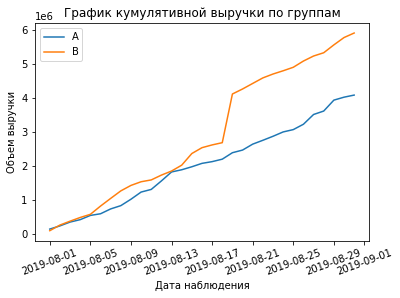

In [14]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='B')
plt.title('График кумулятивной выручки по группам')
plt.xlabel('Дата наблюдения')
plt.ylabel('Объем выручки')
plt.xticks(rotation=20)
plt.legend();

 Выручка почти равномерно увеличивается в течение всего теста. Выручка группы В почти в 1,5 раза больше выручки группы А в конце исследуемого периода.
Однако графики выручки обеих групп в нескольких точках резко растут. Это может сигнализировать о всплесках числа заказов, либо о появлении очень дорогих заказов в выборке. 

Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число заказов:  <a id="4.2"></a> 

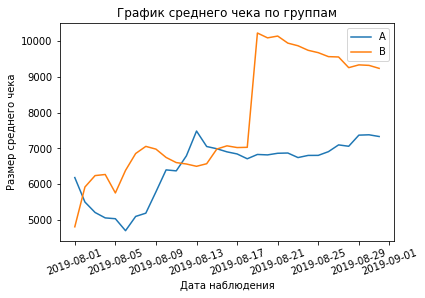

In [15]:
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/cumulativeRevenueB['orders'], label='B')
plt.title('График среднего чека по группам')
plt.xlabel('Дата наблюдения')
plt.ylabel('Размер среднего чека')
plt.xticks(rotation=20)
plt.legend();

Средний чек становится равномерным ближе к концу теста. Возможно, в обе группы теста попали крупные заказы (резкий всплеск на графике). Нужно больше данных, чтобы прийти к реальному среднему чеку и установиться на его уровне.

Построим график относительного различия для среднего чека.  <a id="4.3"></a> 

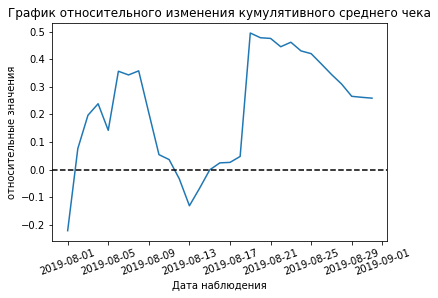

In [16]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = cumulativeRevenueA.merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/mergedCumulativeRevenue['ordersB'])/(mergedCumulativeRevenue['revenueA']/mergedCumulativeRevenue['ordersA'])-1)

# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--')
plt.xticks(rotation=20)
plt.title('График относительного изменения кумулятивного среднего чека')
plt.xlabel('Дата наблюдения')
plt.ylabel('относительные значения');

В нескольких точках график различия между сегментами резко «скачет». Скорее всего результат искажают "выбросы".

Аналогично проанализируем график кумулятивной конверсии.  <a id="4.4"></a> 

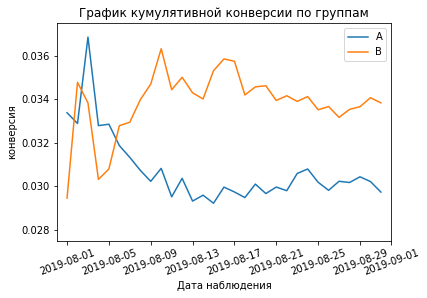

In [17]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='B')
plt.legend()
plt.xticks(rotation=20)
# задаем масштаб осей
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), 0.0275, 0.0375])
plt.title('График кумулятивной конверсии по группам')
plt.xlabel('Дата наблюдения')
plt.ylabel('конверсия');


В начале теста конверсия группы А была больше конверсии группы В,но постепенно сегмент В начинает приходить в норму и его конверсия становится больше конверсии группы А.

Построим график относительного различия кумулятивных конверсий.  <a id="4.5"></a> 

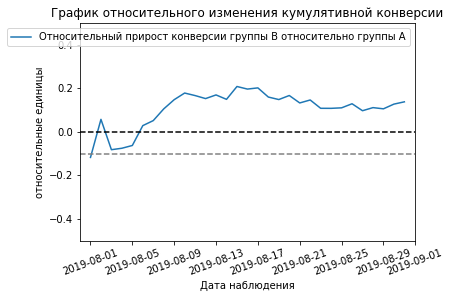

In [18]:
mergedCumulativeConversions = cumulativeDataA[['date','conversion']].merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--')
plt.axis([dt.datetime(2019, 7, 31), dt.datetime(2019, 9, 1), -0.5, 0.5])
plt.xticks(rotation=20)
plt.title('График относительного изменения кумулятивной конверсии')
plt.xlabel('Дата наблюдения')
plt.ylabel('относительные единицы');

Почти изначально конверсия группы В лидирует относительно конверсии группы А. Она зафикисровалась примерно на уровне 20% прироста относительно группы А.

Построем точечный график количества заказов по пользователям. <a id="4.6"></a> 

In [19]:
#создадим датафрейм с данными о числе заказов по пользователям
ordersByUsers=(
    orders.groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    .rename(columns={'transaction_id':'orders'})
    .sort_values(by='orders',ascending=False)
)

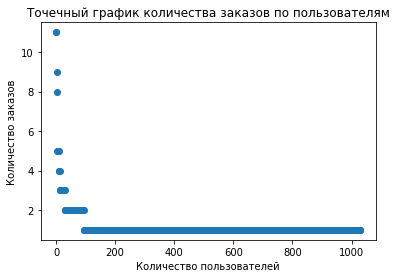

In [20]:
# серия из чисел от 0 до количества наблюдений в ordersByUsers
x_values = pd.Series(range(0,len(ordersByUsers)))

plt.scatter(x_values, ordersByUsers['orders'])
plt.title('Точечный график количества заказов по пользователям')
plt.xlabel('Количество пользователей')
plt.ylabel('Количество заказов');

Пользователей, совершивших более 2 заказов очень мало. Но для того, чтобы определить, 2 заказа это много или мало, необходимо рассчитать перцентили заказов.  <a id="4.7"></a> 

In [21]:
# Метод np.percentile('column', [percentile1, percentile2, percentile3]) находит перцентили.
print(np.percentile(ordersByUsers['orders'], [95, 99]))

[2. 4.]


Не более 5% пользователей совершали более 2 заказов, не более 1 % пользователей - больше четырех заказов.  <a id="4.8"></a> 

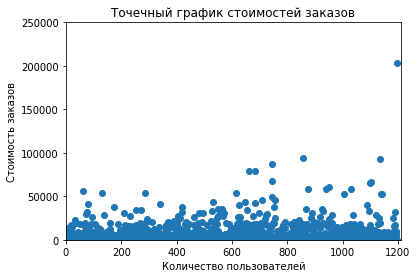

In [22]:
#Построем точечный график стоимостей заказов
x_values = pd.Series(range(0, len(orders['revenue'])))
plt.scatter(x_values, orders['revenue'])
plt.axis([0, 1210, 0, 250000])
plt.title('Точечный график стоимостей заказов')
plt.xlabel('Количество пользователей')
plt.ylabel('Стоимость заказов');

Заказов стоимостью выше 50 тыс рублей почти нет, есть отдельные выбросы в районе 210 тыс рублей и заказ стоимостью выше 1,2 млн рублей. Посчитаем выборочные перцентили.  <a id="4.9"></a> 

In [23]:
print(np.percentile(orders['revenue'],[95,99]))

[28000.  58233.2]


Не более, чем у 5% заказов стоимость выше 28 тысяч рублей. И не более чем у 1% чек выше 58 тысячи рыблей.

Посчитаем статистическую значимость различий в конверсии и среднем чеке между группами по «сырым» данным — без удаления аномальных пользователей.  <a id="4.10"></a> 

In [24]:
#считаем количество пользователей в выбранную дату в группе A:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']] 
visitorsADaily.columns = ['date', 'visitorsPerDateA']

# количество пользователей до выбранной даты включительно в группе A:
visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

#количество пользователей в выбранную дату в группе B:
visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

# количество пользователей до выбранной даты включительно в группе B:
visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

#количество заказов и суммарная выручка в выбранную дату в группе A;
ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

#суммарное число заказов и суммарная выручка до выбранной даты включительно в группе A;
ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

#количество заказов и суммарная выручка в выбранную дату в группе В;
ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

#суммарное число заказов и суммарная выручка до выбранной даты включительно в группе В;
ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

#объединяем все таблицы в одну:
data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

display(data.head(5))

,date,ordersPerDateA,revenuePerDateA,ordersPerDateB,revenuePerDateB,ordersCummulativeA,revenueCummulativeA,ordersCummulativeB,revenueCummulativeB,visitorsPerDateA,visitorsPerDateB,visitorsCummulativeA,visitorsCummulativeB
0,2019-08-01,24,148579,21,101217,24,148579,21,101217,719,713,719,713
1,2019-08-02,20,93822,24,165531,44,242401,45,266748,619,581,1338,1294
2,2019-08-03,24,112473,16,114248,68,354874,61,380996,507,509,1845,1803
3,2019-08-04,16,70825,17,108571,84,425699,78,489567,717,770,2562,2573
4,2019-08-05,25,124218,23,92428,109,549917,101,581995,756,707,3318,3280


In [25]:
#Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
#В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов.

ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    .rename(columns={'visitor_id':'userId', 'transaction_id':'orders'})
)

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
    .rename(columns={'visitor_id':'userId', 'transaction_id':'orders'})
)

In [26]:
#Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов. 
#Тем, кто ничего не заказал, будут соответствовать нули. 
#Это нужно, чтобы подготовить выборки к проверке критерием Манна-Уитни.

sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)


В sampleA сохранили выборку, где каждый элемент — число заказов определённого пользователя, в том числе ноль. Значит, число элементов sampleA — это количество пользователей, сумма всех элементов — количество заказов. Чтобы получить конверсию в группе, поделим сумму заказов на число пользователей — найдём среднее в выборке sampleA методом mean(). Аналогично найдём конверсию группы B: SampleB.mean().
Выведем относительный прирост конверсии группы B: конверсия группы B / конверсия группы A - 1. Округлим до трёх знаков после запятой.

Формируем нулевую и альтернативную гипотезу.  
Н0: Конверсия группы А не имеет статистически значимое различие от конверсии группы В  
Н1: Конверсия группы А имеет статистически значимое различие от конверсии группы В

In [27]:
print("{0:.3f}".format(st.mannwhitneyu(sampleA, sampleB)[1]))

print("{0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

0.017
0.138


Первое число — p-value = 0.008 меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, отвергаем. Относительный выигрыш группы B равен 13.8% — второе число в выводе.

Формируем нулевую и альтернативную гипотезу.  
Н0: Средний чек группы А не имеет статистически значимое различие от среднего чека группы В  
Н1: Средний чек группы А имеет статистически значимое различие от среднего чека группы В

In [28]:
#аналогично рассчитаем статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным

print('{0:.3f}'.format(st.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('{0:.3f}'.format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1))

0.729
0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет. Однако, средний чек группы B значительно выше среднего чека группы A (на 25,9%).

Далее проведем аналогичные расчеты статистической значимости по "очищенным" данным. Исходя из расчета выборочных перцентилей, проведем срез данных:с числом заказов больше 2 — usersWithManyOrders и пользователей, совершивших заказы дороже 30 000 — usersWithExpensiveOrders. Объединим их в таблице abnormalUsers.  <a id="4.11"></a> 

In [29]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > 2]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > 2]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > 30000]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)

print(f'Всего {abnormalUsers.shape} аномальных пользователей')

Всего (68,) аномальных пользователей


In [30]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

Формируем нулевую и альтернативную гипотезу.  
Н0: Конверсия группы А не имеет статистически значимое различие от конверсии группы В  
Н1: Конверсия группы А имеет статистически значимое различие от конверсии группы В

In [31]:
print('{0:.3f}'.format(st.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('{0:.3f}'.format(sampleBFiltered.mean()/sampleAFiltered.mean()-1))

0.013
0.172


Результаты по конверсии практически не изменились. Нулевую гипотезу о том, что статистически значимых различий в конверсии между группами нет, также отвергаем (p-value<0.05). Относительный выигрыш группы B равен 17.2% 

Формируем нулевую и альтернативную гипотезу.  
Н0: Средний чек группы А не имеет статистически значимое различие от среднего чека группы В  
Н1: Средний чек группы А имеет статистически значимое различие от среднего чека группы В

In [32]:
#посчитаем по среднему чеку:
print(
    '{0:.3f}'.format(
        st.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "{0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
)

0.720
-0.023


Статистическая разница между двумя группами по среднему чеку также не выявлена. Но разница между сегментами резко изменилась в противоположную сторону: средний чек группы В ниже на 2,3%, чем в группе А.

## Выводы и решение по результатам А/В теста  <a id="5"></a> 

- Есть статистически значимое различие по конверсии между группами и по «сырым», и по данным после фильтрации аномалий. Относительный выигрыш группы В - 17%.
- Статистическая разница между двумя группами по среднему чеку не выявлена.
- График различия конверсии между группами сообщает, что результаты группы B превосходят результаты группы A и видна тенденция роста. 
- [График относительного изменения кумулятивного среднего чека](#4.3) неоднороден из-за выбросов, по нему нельзя сделать корректные выводы.
- По [графику кумулятивной выручки по группам](#4.1) видно, что выручка группы В превышает выручку группы А на протяжении всего теста.    

**Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Победа группы В.**